**Installing the tensorflow**

In [5]:
!pip install "tensorflow<2.11"

**Importing the dependencies**

In [23]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from copy import deepcopy

In [7]:
df= pd.read_csv('/content/MSFT (1).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9459,2023-09-25,316.589996,317.670013,315.000000,317.540009,317.540009,17836000
9460,2023-09-26,315.130005,315.880005,310.019989,312.140015,312.140015,26297600
9461,2023-09-27,312.299988,314.299988,309.690002,312.790009,312.790009,19410100
9462,2023-09-28,310.989990,315.480011,309.450012,313.640015,313.640015,19683600


In [8]:
df=df.drop(['Open','High','Low','Volume','Adj Close'], axis=1)


In [9]:
df


,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9459,2023-09-25,317.540009
9460,2023-09-26,312.140015
9461,2023-09-27,312.790009
9462,2023-09-28,313.640015


In [10]:
def str_to_datetime(s):
  split= s.split('-')
  year, month, day= int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month= month, day=day)


In [11]:
datetime_object= str_to_datetime('1986-03-13')
datetime_object

datetime.datetime(1986, 3, 13, 0, 0)

In [12]:
df['Date']= df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9459   2023-09-25
9460   2023-09-26
9461   2023-09-27
9462   2023-09-28
9463   2023-09-29
Name: Date, Length: 9464, dtype: datetime64[ns]

In [13]:
df.index= df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-09-25,317.540009
2023-09-26,312.140015
2023-09-27,312.790009


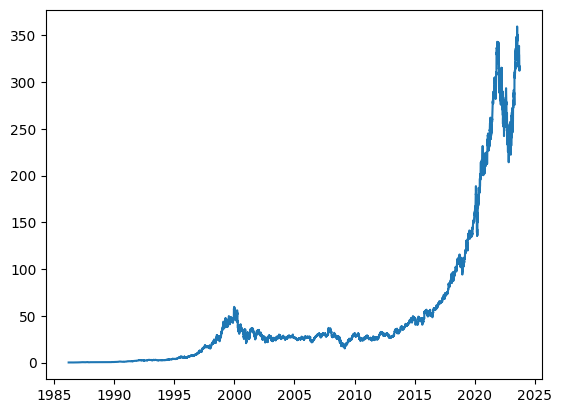

In [14]:
plt.plot(df.index, df['Close'])

In [15]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [16]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np= windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

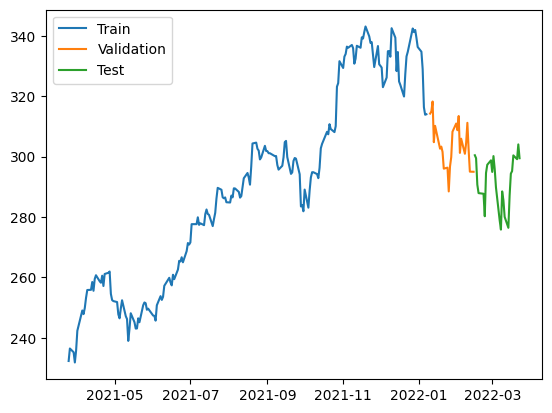

In [17]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [18]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 5s 149ms/step - loss: 84833.6484 - mean_absolute_error: 289.5226 - val_loss: 92532.8828 - val_mean_absolute_error: 304.1051
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 84586.7344 - mean_absolute_error: 289.0962 - val_loss: 92242.0078 - val_mean_absolute_error: 303.6264
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 84257.1406 - mean_absolute_error: 288.5234 - val_loss: 91839.0078 - val_mean_absolute_error: 302.9621
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 83872.6641 - mean_absolute_error: 287.8580 - val_loss: 91405.4688 - val_mean_absolute_error: 302.2458
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 83435.6953 - mean_absolute_error: 287.0966 - val_loss: 90898.7500 - val_mean_absolute_error: 301.4063
Epoch 6/100
7/7 [==============================] - 0s 18ms/step - loss: 82899.1797 - mean_absolute_error: 286.1622 - val_loss: 90

7/7 [==============================] - 1s 5ms/step


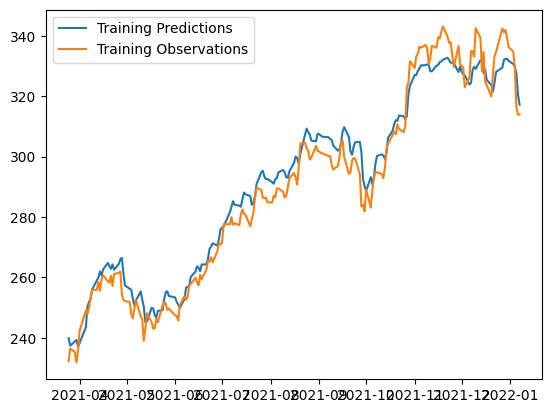

In [19]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 48ms/step


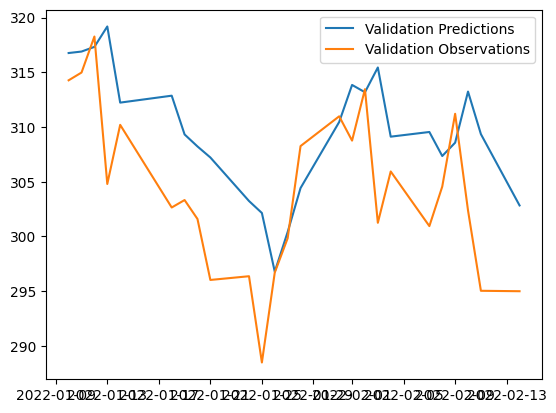

In [20]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 36ms/step


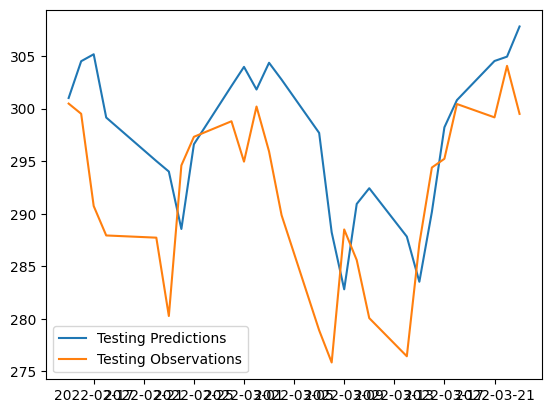

In [21]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

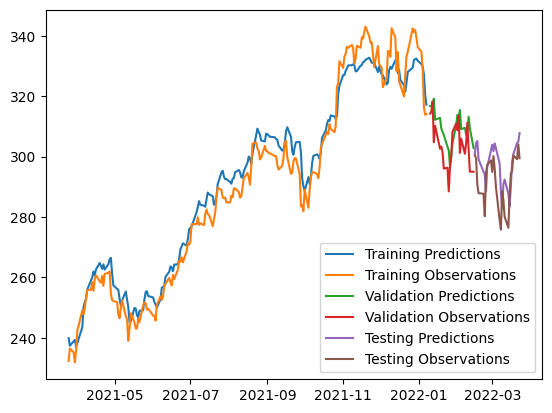

In [22]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [24]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 24ms/step


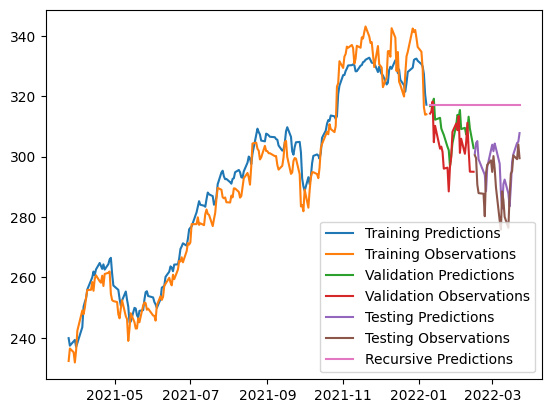

In [25]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

**END**